In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from scipy import ndimage
import numpy.ma as ma

##functions used


In [ ]:
def show_image(input_image): 
  rotated_img = ndimage.rotate(input_image, 90)
  plt.imshow(rotated_img, cmap='gray')


def tissue_model_histogram(tissue_model_array, tissue_str):
  tissue_histogram_val = np.histogram(tissue_model_array.astype(int), bins=np.arange(np.max(tissue_model_array.astype(int))+1),range= (tissue_model_array.min,tissue_model_array.max))
  _ = plt.hist(tissue_model_array.astype(int), bins=np.arange(np.max(tissue_model_array.astype(int))+1))  # arguments are passed to np.histogram
  plt.title("Histogram for "+ tissue_str +" tissue model")
  plt.show()
  return tissue_histogram_val

#Loading the Training Images and labels 


In [ ]:
slice_no = 130
l=sorted(os.listdir("/content/drive/MyDrive/labels/"))
im=sorted(os.listdir("/content/drive/MyDrive/images/"))
print(l[0])
print(im)

# initailize the training label and image
load_labels = nib.load("/content/drive/MyDrive/labels/" + l[0])
training_labels=load_labels.get_fdata()

load_images = nib.load("/content/drive/MyDrive/images/" + im[0])
training_image=load_images.get_fdata()

#reshape and make a vector out of image  
labels_vector =  np.reshape(training_labels, training_labels.shape[0]*training_labels.shape[1]*training_labels.shape[2], order='F')
images_vector =  np.reshape(training_image, training_image.shape[0]*training_image.shape[1]*training_image.shape[2], order='F')

#run all the images, here we have 14 images 
for i in range (1,14):
  load_labels = nib.load("/content/drive/MyDrive/labels/"+l[i])
  training_labels=load_labels.get_fdata()
  load_images = nib.load("/content/drive/MyDrive/images/"+im[i])
  training_image=load_images.get_fdata()

#stack all 14 labels and images 
  labels_vector = np.vstack((labels_vector, np.reshape(training_labels, training_labels.shape[0]*training_labels.shape[1]*training_labels.shape[2], order='F')))
  images_vector = np.vstack((images_vector, np.reshape(training_image, training_image.shape[0]*training_image.shape[1]*training_image.shape[2], order='F')))


result.nii
['result.nii', 'result1.nii', 'result10.nii', 'result11.nii', 'result12.nii', 'result13.nii', 'result2.nii', 'result3.nii', 'result4.nii', 'result5.nii', 'result6.nii', 'result7.nii', 'result8.nii', 'result9.nii']


##Print the vectors


In [ ]:
print(len(labels_vector))
print(len(images_vector))

14
14


#Tissue Models

##Generating the Tissue Model

[348. 565. 266. ... 816. 606. 715.]
[  1.   1.   1. ... 816. 606. 715.]


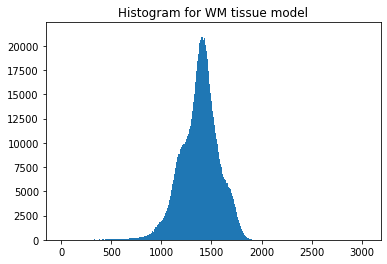

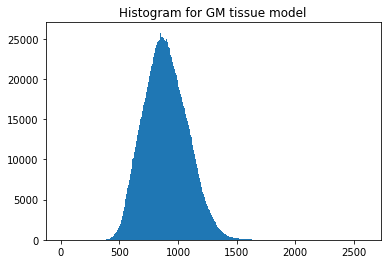

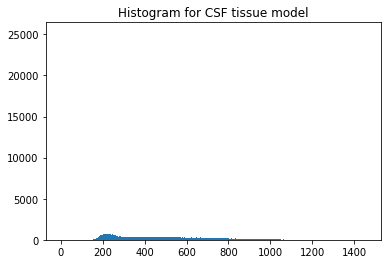

In [ ]:
#initialize vector for each class

GM_tissue_model_vector = []
WM_tissue_model_vector = []
CSF_tissue_model_vector = []

#from the labels GM=3, WM=2 and CSF=1
#concatenate all the intensities of each label in a single vector wrt to images 
for i in range(len(images_vector)):
  im_mask_GM = (labels_vector[i,:] == 3);
  GM_compressed = ma.array(images_vector[i,:], mask=~im_mask_GM).compressed()
  GM_tissue_model_vector = np.concatenate((GM_tissue_model_vector, GM_compressed))

  im_mask_WM = (labels_vector[i,:] == 2);
  WM_compressed = ma.array(images_vector[i,:], mask=~im_mask_WM).compressed()
  WM_tissue_model_vector = np.concatenate((WM_tissue_model_vector, WM_compressed))   

  im_mask_CSF = (labels_vector[i,:] == 1);
  CSF_compressed = ma.array(images_vector[i,:], mask=~im_mask_CSF).compressed()
  CSF_tissue_model_vector = np.concatenate((CSF_tissue_model_vector, CSF_compressed)) 


print(CSF_compressed)
print( CSF_tissue_model_vector)
WM_histogram = tissue_model_histogram(WM_tissue_model_vector,"WM")
GM_histogram = tissue_model_histogram(GM_tissue_model_vector,"GM")
CSF_histogram = tissue_model_histogram(CSF_tissue_model_vector,"CSF")


##Tissue Model Normaliztion

In [ ]:
tissue_model_array_norm = np.zeros((3,np.amax([WM_histogram[0].shape[0], GM_histogram[0].shape[0], CSF_histogram[0].shape[0]])),dtype=int)

tissue_model_array_norm[0,0:WM_histogram[0].shape[0]]= WM_histogram[0]
tissue_model_array_norm[1,0:GM_histogram[0].shape[0]]= GM_histogram[0]
tissue_model_array_norm[2,0:CSF_histogram[0].shape[0]]= CSF_histogram[0]

WM_histogram_norm = np.nan_to_num(tissue_model_array_norm[0,:]/(tissue_model_array_norm[0,:]+tissue_model_array_norm[1,:]+tissue_model_array_norm[2,:]))
GM_histogram_norm = np.nan_to_num(tissue_model_array_norm[1,:]/(tissue_model_array_norm[0,:]+tissue_model_array_norm[1,:]+tissue_model_array_norm[2,:]))
CSF_histogram_norm = np.nan_to_num(tissue_model_array_norm[2,:]/(tissue_model_array_norm[0,:]+tissue_model_array_norm[1,:]+tissue_model_array_norm[2,:]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


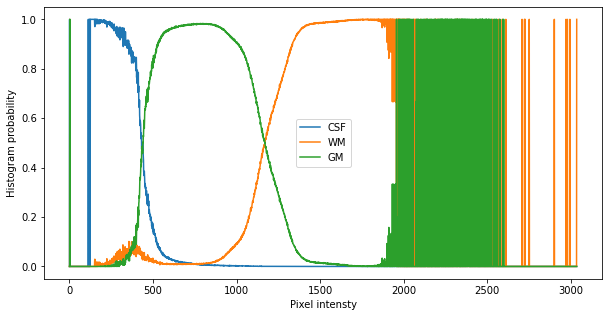

In [ ]:
plt.figure(figsize=(10,5))
#plt.subplot(1,3,1)
plt.plot(np.arange(np.max(CSF_histogram_norm.shape[0])),CSF_histogram_norm, label = "CSF")
#plt.subplot(1,3,2)
plt.plot(np.arange(np.max(WM_histogram_norm.shape[0])),WM_histogram_norm, label = "WM")
#plt.subplot(1,3,3)
plt.plot(np.arange(np.max(GM_histogram_norm.shape[0])),GM_histogram_norm, label = "GM")


# naming the x axis 
plt.xlabel('Pixel intensty') 
# naming the y axis 
plt.ylabel('Histogram probability') 

# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 


##Saving the Tissue Models

In [ ]:
np.save("/content/drive/My Drive/tissue_model/WM_histogram_norm.npy",WM_histogram_norm)
np.save("/content/drive/My Drive/tissue_model/GM_histogram_norm.npy",GM_histogram_norm)
np.save("/content/drive/My Drive/tissue_model/CSF_histogram_norm.npy",CSF_histogram_norm)

#Atlases

##Generating Probablistic Atlas by using the mean approach 

In [ ]:
CSF_array = np.multiply((labels_vector==1), 1) 
print(CSF_array)
CSF_vect = np.mean(CSF_array, axis=0)
print(CSF_vect)
CSF_prob_map = np.reshape(CSF_vect, (256, 287, 256), order='F')
print(CSF_prob_map)
WM_array = np.multiply((labels_vector==2), 1) 
WM_vect = np.mean(WM_array, axis=0)
WM_prob_map = np.reshape(WM_vect, (256, 287, 256), order='F')

GM_array = np.multiply((labels_vector==3), 1) 
GM_vect = np.mean(GM_array, axis=0)
GM_prob_map = np.reshape(GM_vect, (256, 287, 256), order='F')

tissue_model_vect = np.mean(images_vector, axis=0)
tissue_model = np.reshape(tissue_model_vect, (256, 287, 256), order='F')

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0. 0. 0. ... 0. 0. 0.] 2
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  

##Plotting Atlas

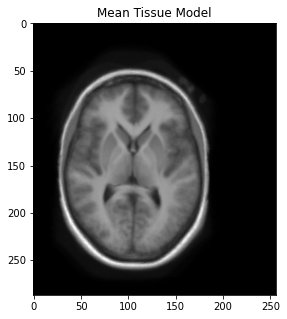

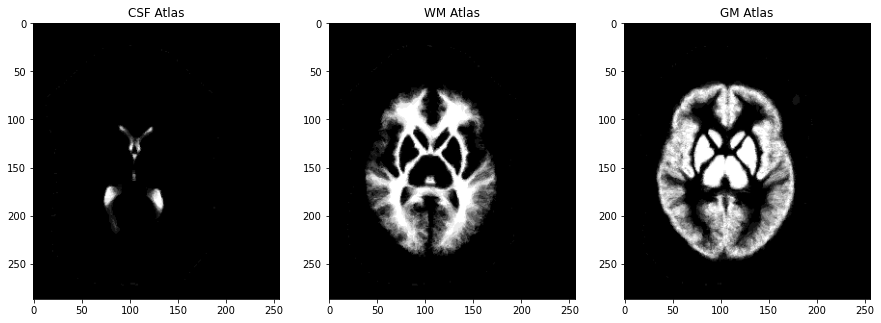

In [ ]:
plt.figure(figsize=(5,5))
plt.title("Mean Tissue Model")
show_image(tissue_model[:,:,slice_no])

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title("CSF Atlas")
show_image(CSF_prob_map[:,:,slice_no])
plt.subplot(1,3,2)
plt.title("WM Atlas")
show_image(WM_prob_map[:,:,slice_no])
plt.subplot(1,3,3)
plt.title("GM Atlas")
show_image(GM_prob_map[:,:,slice_no])


##Saving Atlases

In [ ]:
save_img = nib.Nifti1Image(GM_prob_map, load_images.affine, load_images.header)
nib.save(save_img, 'GM_prob_map.nii.gz')
save_img = nib.Nifti1Image(WM_prob_map, load_images.affine, load_images.header)
nib.save(save_img, 'WM_prob_map.nii.gz')
save_img = nib.Nifti1Image(CSF_prob_map, load_images.affine, load_images.header)
nib.save(save_img, 'CSF_prob_map.nii.gz')
save_img = nib.Nifti1Image(tissue_model, load_images.affine, load_images.header)
nib.save(save_img, 'tissue_model.nii.gz')
